In [1]:
!pip install datasets pandas matplotlib seqeval -q


In [2]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
from datasets import load_dataset
import seqeval
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score      
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


# Parsing du fichier

Dans le serveur, localiser le fichier à copier (en général, dans les checkpoints) qui s'appelle `trainer_state.json`. Le copier avec `scp`. Voici un exemple de syntaxe. 

`scp auXXXXX@ens.ad.etsmtl.ca@logti-hyperbole.ens.ad.etsmtl.ca:~/job/output/checkpoint-32500/trainer_state.json .`

In [3]:
trainer_state_file = 'local/trainer_state.json'

# Load the trainer state
if os.path.exists(trainer_state_file):
    with open(trainer_state_file, 'r') as f:
        trainer_state = json.load(f)
else:
    print(f"Trainer state file {trainer_state_file} not found. Please check the path.")
        

In [4]:
print(trainer_state.keys())

dict_keys(['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])


# Fonction de coût 

In [ ]:
log_history = trainer_state['log_history']

# Convert the log history to a DataFrame
df = pd.DataFrame(log_history)
df.head()

,epoch,grad_norm,learning_rate,loss,step,eval_T005_f1,eval_T005_number,eval_T005_precision,eval_T005_recall,eval_T007_f1,...,eval_overall_precision,eval_overall_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,0.343643,2.743635,0.000048,0.7214,500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.687285,1.849224,0.000047,0.5327,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000000,NaN,NaN,NaN,1455,0.0,25.0,0.0,0.0,0.078947,...,0.553754,0.574782,3.3696,876.656,109.805,NaN,NaN,NaN,NaN,NaN
3,1.030928,2.297437,0.000045,0.4762,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.374570,2.941913,0.000043,0.3839,2000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# delete lines with NaN values in loss 
df = df.dropna(subset=['loss'])

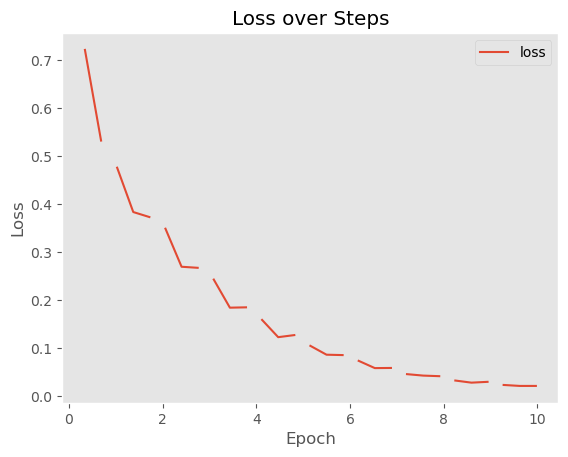

In [6]:

df.plot(x='epoch', y='loss', title='Loss over Steps')
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.grid()
plt.show()